In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
from config import mod5_params, mod5_shocks, fred_dict, recession_dict

In [3]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results
from src.process_data import load_data

import numpy as np
import pandas as pd

import os

from config import plt_config
plt.rcParams.update(plt_config)

load model

In [4]:
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod7_nk.gcn'), verbose=True)

Model Building Complete.
Found:
	24 equations
	24 variables
	The following "variables" were defined as constants and have been substituted away:
		B_t
	4 stochastic shocks
		 0 / 4 has a defined prior. 
	17 parameters
		 0 / 17 has a defined prior. 
	2 calibrating equations
	2 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [5]:
# assign parameters
# mod.free_param_dict.update(mod5_params)
mod.free_param_dict

{'alpha': 0.35,
 'beta': 0.99,
 'delta': 0.025,
 'eta_p': 0.75,
 'eta_w': 0.75,
 'gamma_I': 10.0,
 'gamma_R': 0.9,
 'gamma_Y': 0.05,
 'gamma_pi': 1.5,
 'phi_H': 0.5,
 'psi_p': 0.6,
 'psi_w': 0.782,
 'rho_pi_dot': 0.924,
 'rho_preference': 0.95,
 'rho_technology': 0.95,
 'sigma_C': 2.0,
 'sigma_L': 1.5}

In [30]:
mod.steady_state()
mod.solve_model()
mod.check_bk()

Steady state found! Sum of squared residuals is 1.3485582662688972e-25
Gensys found a unique solution.
Policy matrices have been stored in attributes model.P, model.Q, model.R, and model.S
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


## Estimation

#### load data

In [31]:
df = load_data('prepro_data.csv', DATA_DIR, fred_dict)
df = df.rename(columns={'pi_s': 'pi'}).drop(['pi_c', 'Ix', 'Zx'], axis=1)
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


In [9]:
mod.variables

[C_t,
 Div_t,
 I_t,
 K_t,
 LHS_t,
 LHS_w_t,
 L_t,
 RHS_t,
 RHS_w_t,
 TC_t,
 U_t,
 Y_t,
 lambda_t,
 mc_t,
 pi_obj_t,
 pi_star_t,
 pi_t,
 q_t,
 r_G_t,
 r_t,
 shock_preference_t,
 shock_technology_t,
 w_star_t,
 w_t]

In [27]:
df.describe().round(5)

,Y,pi,r,I,C,L,w
count,66.00000,66.00000,66.00000,66.00000,66.00000,66.00000,66.00000
mean,-0.00000,2.32633,1.12591,-0.00000,-0.00000,-0.00000,-0.00000
std,430.65975,0.79129,1.61613,178.95379,0.61536,2.71891,0.17734
min,-2388.66570,0.67527,0.05000,-740.98264,-1.55953,-14.13286,-0.42244
25%,-95.89445,1.99074,0.10000,-84.80465,-0.16242,-0.63117,-0.07418
50%,12.01180,2.28890,0.17500,46.74330,0.02653,0.32805,0.00102
75%,189.21019,2.56995,1.68750,111.49403,0.17296,1.48726,0.04471
max,979.24614,5.62533,5.26000,347.82778,2.44197,3.22275,0.87005


In [10]:
mod.shocks

[epsilon_R_t, epsilon_Y_t, epsilon_pi_t, epsilon_preference_t]

In [14]:
StatsMod = compile_to_statsmodels(mod)

# parameters that we want to estimate, if not specified value will be taken from GCN file
param_start_dict = {
    'rho_preference':0.85
                   }

# starting value for the shock's standard deviation
shock_start_dict = {
    'epsilon_preference':0.5
                    }

# assume that the true value deviates with a σ, specified below
noise_start_dict = {
        'Y':0.01
}

# define parameter search space e.g. 0 < α < 1, as suggested by Cobb-Douglas function
param_transforms = {
    'rho_preference':IntervalTransformer(low=1e-2, high=0.99999, slope=1),
}
mod_stats = StatsMod(train[["Y", "pi"]],
                 param_start_dict = param_start_dict,
                  shock_start_dict = shock_start_dict,
                  noise_start_dict = noise_start_dict,
                  param_transforms = param_transforms,
                  shock_transforms=None, 
                  noise_transforms=None, 
                  initialization='stationary')

In [15]:
%%capture
# the basinhopping algorithm, mixes different approaches 
mod_res = mod_stats.fit(method='basinhopping')

In [16]:
mod_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:            ['Y', 'pi']   No. Observations:                   53
Model:                      DSGEModel   Log Likelihood                -650.010
Date:                Tue, 21 Feb 2023   AIC                           1306.020
Time:                        11:54:18   BIC                           1311.931
Sample:                    04-01-2006   HQIC                          1308.293
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
rho_preference                0.0100     18.072      0.001      1.000     -35.410      35.430
sigma2.epsilon_preference   679.8766    156.131      4.355      0.000     373.865     985.888
sigma2.Y                   5619.1662    701.186      8.014      0.000    4244.867    6993.465
===================================================================================
Ljung-Box (L1) (Q):           32.98, 34.08   Jarque-Bera (JB):         20.98, 20.28
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.25, 0.25   Skew:                      -1.23, 1.24
Prob(H) (two-sided):            0.01, 0.01   Kurtosis:                   4.87, 4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

In [18]:
plot_vars = ["C", "Y", "pi", "r", "L"]

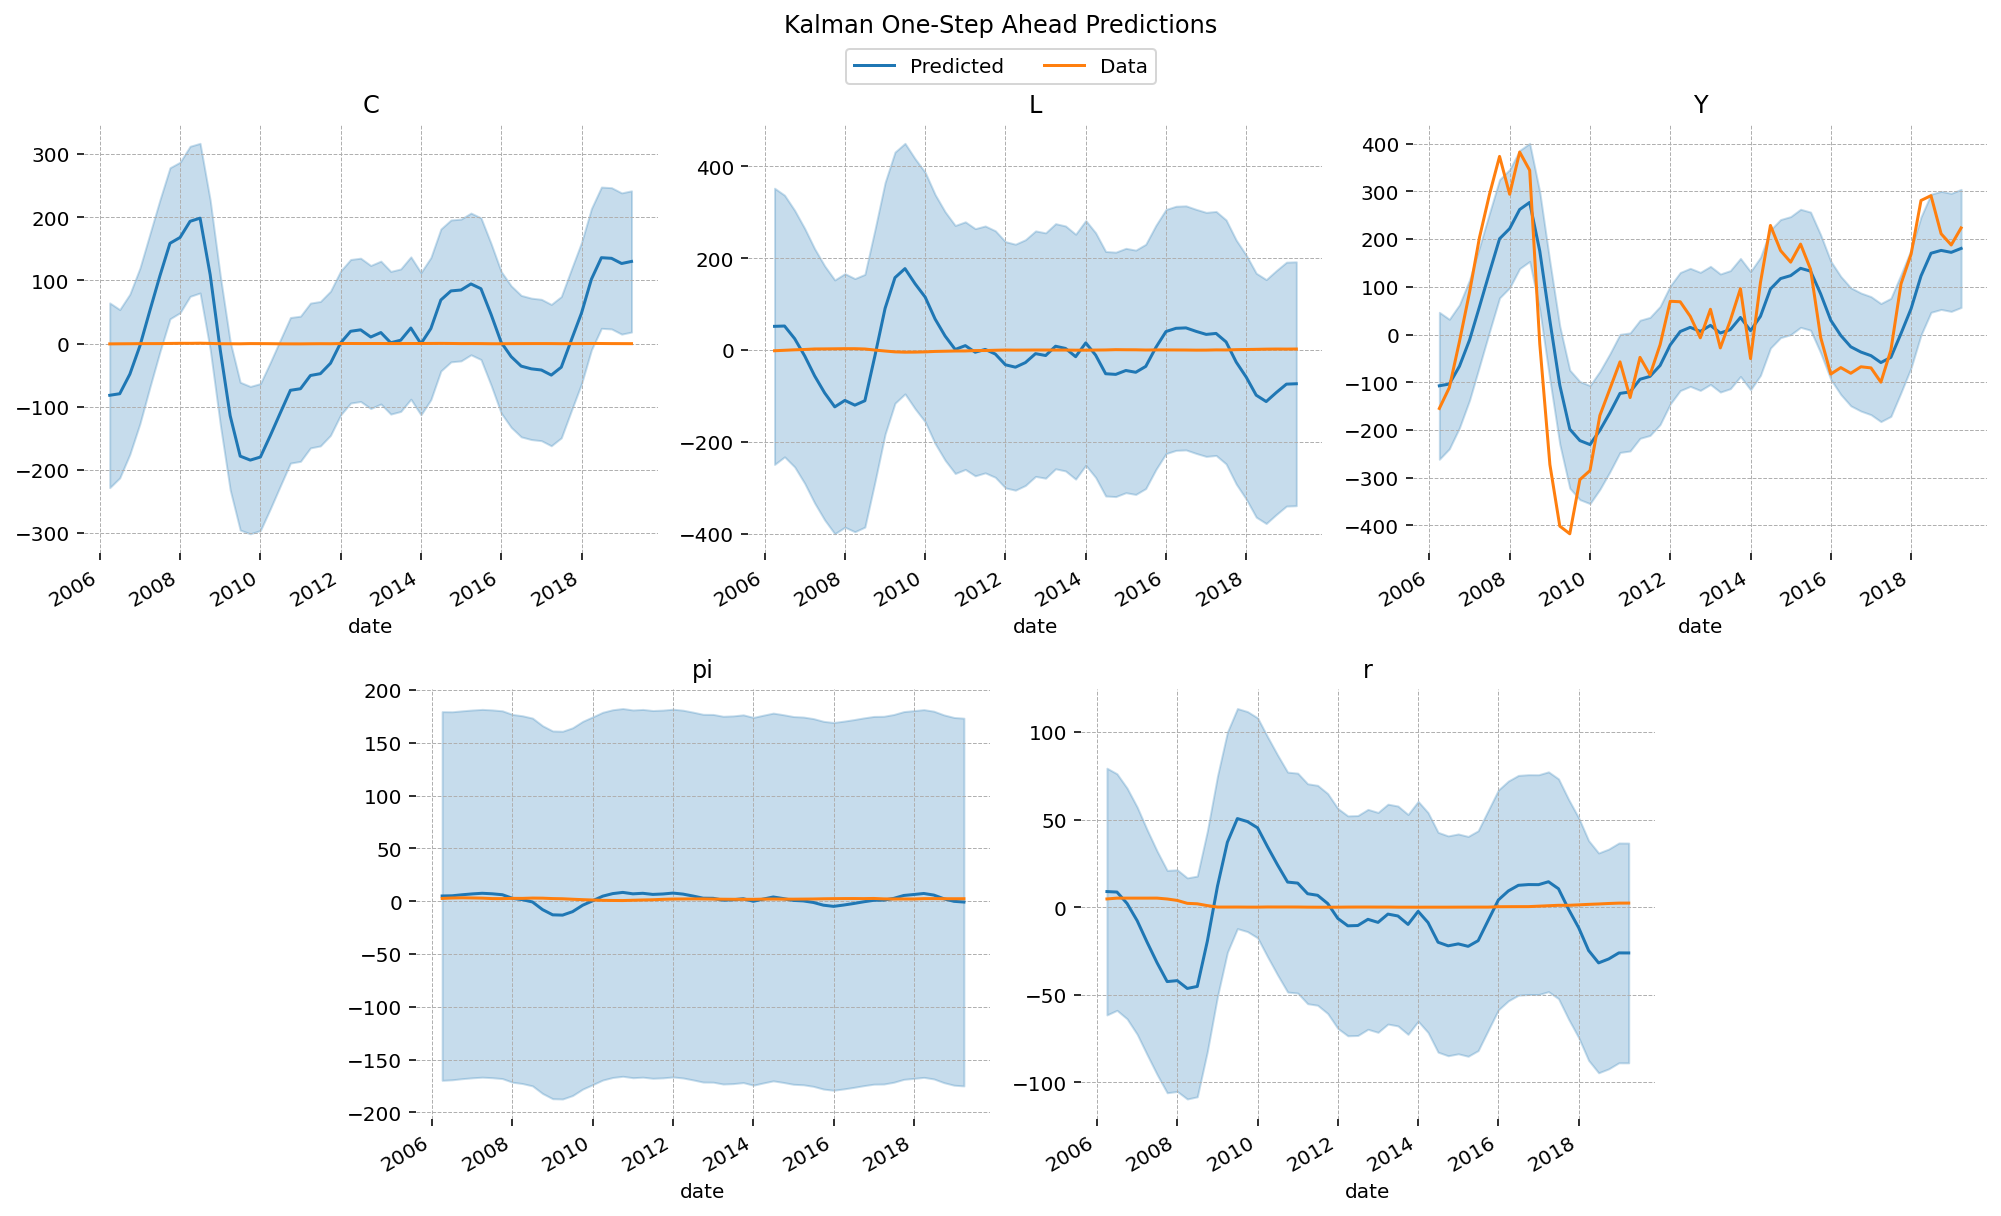

In [19]:
plot_sm_results(mod_res, train, var_names=plot_vars)

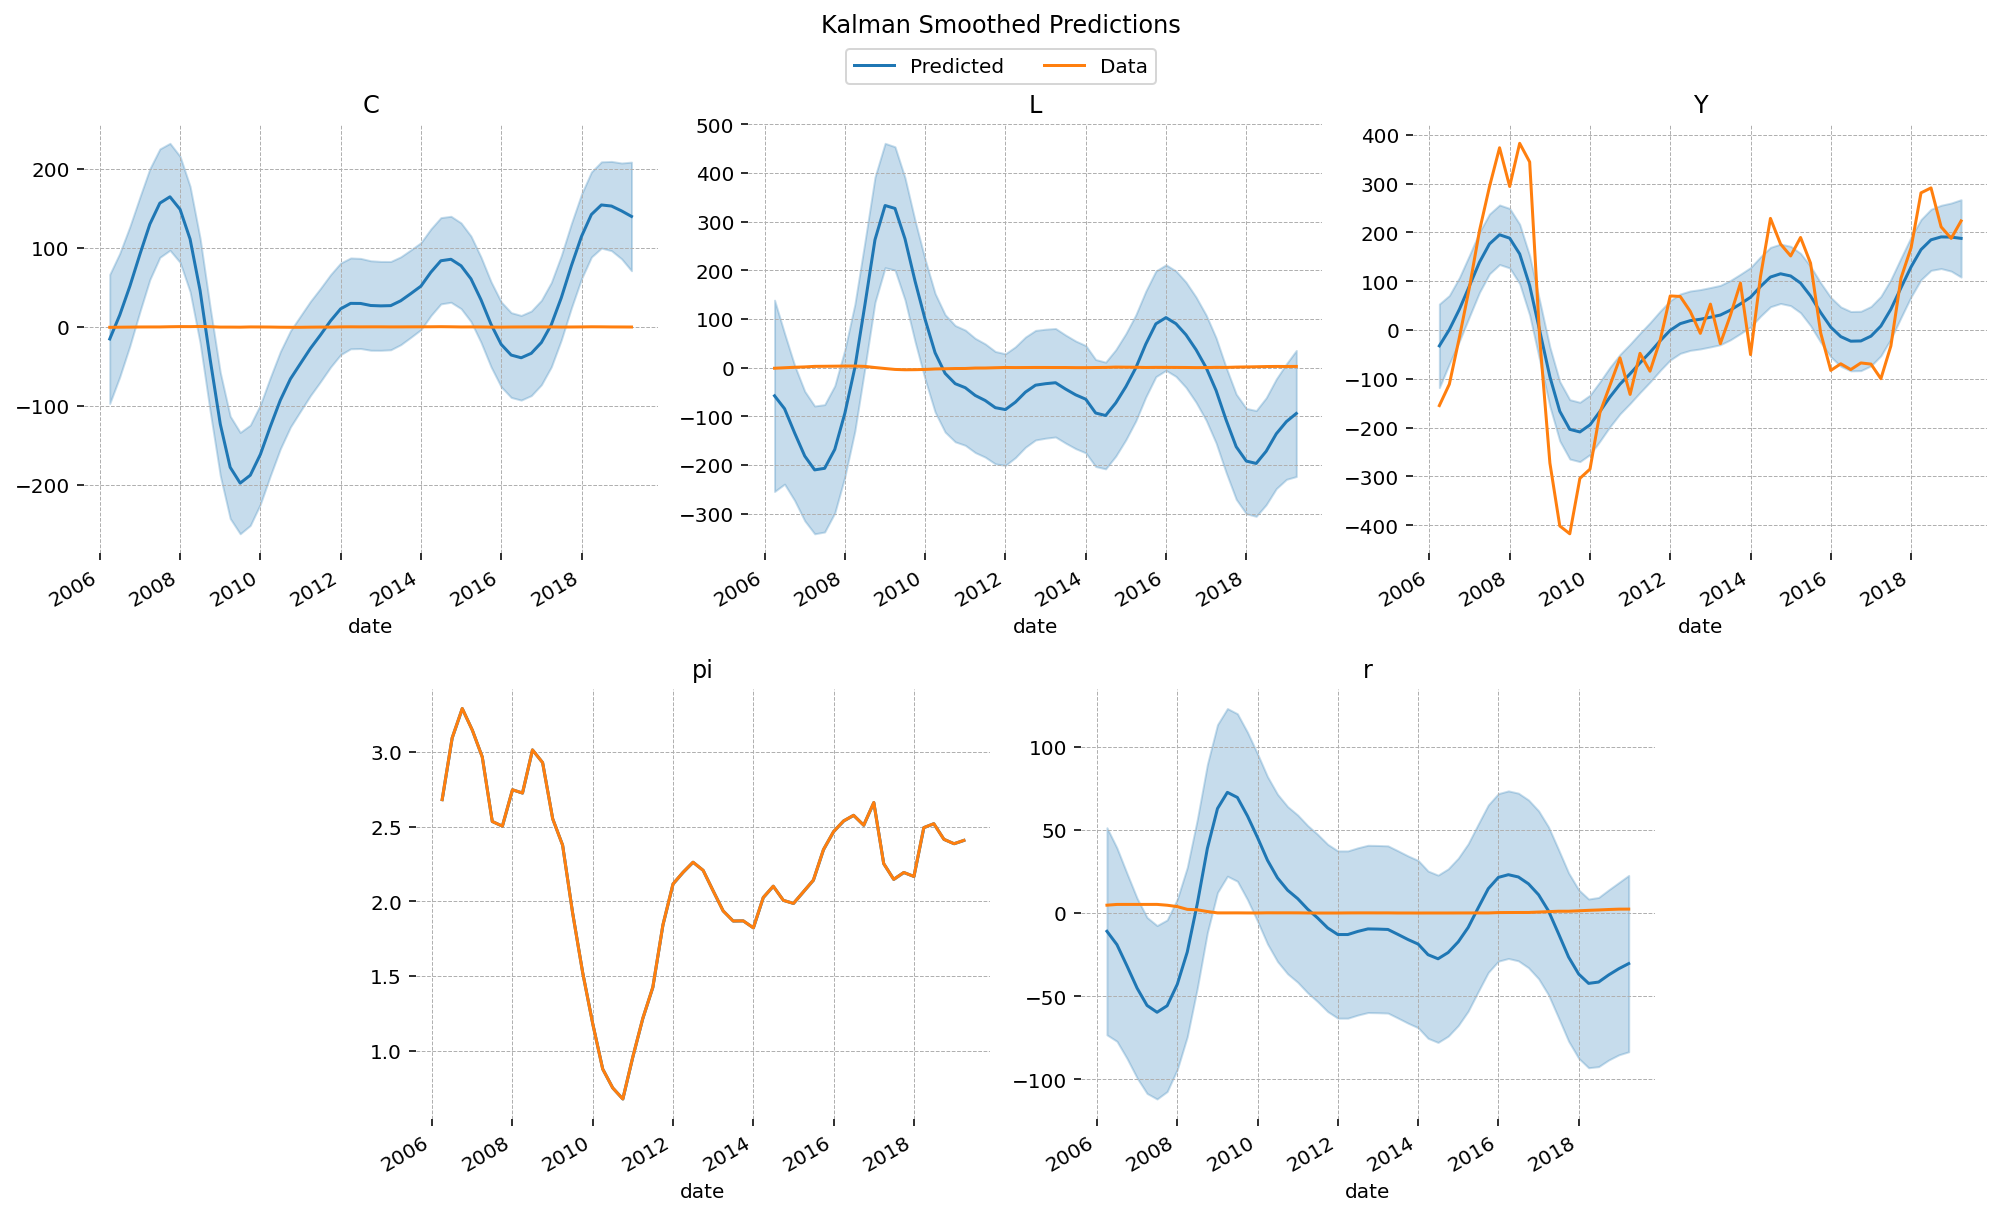

In [20]:
plot_sm_results(mod_res, train, 'smoothed', var_names=plot_vars)

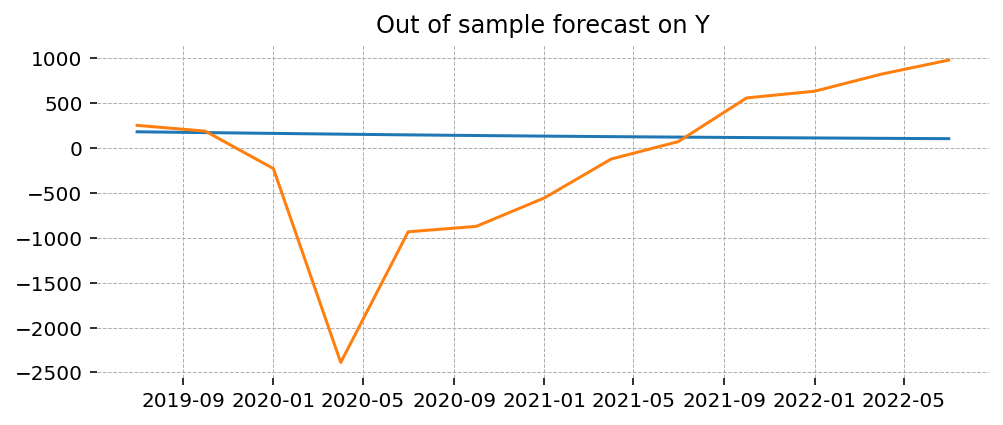

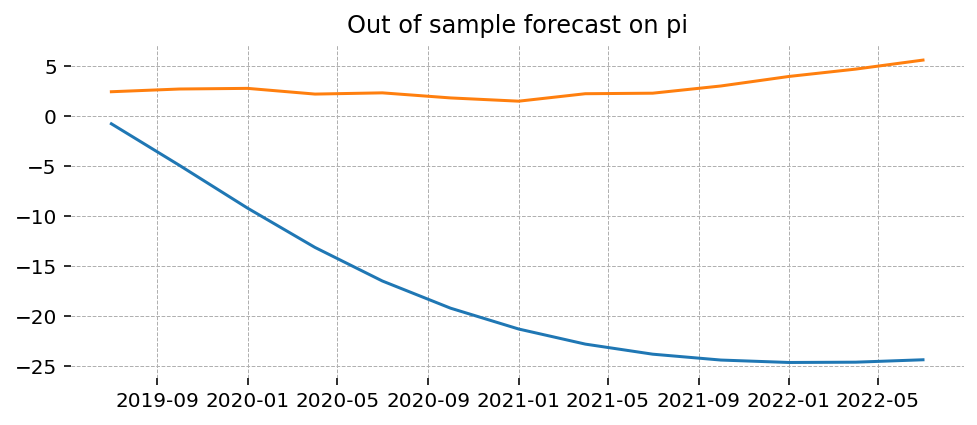

In [21]:
mod_for = mod_res.get_forecast(len(test))

mu = mod_for.predicted_mean
if type(mu) == pd.Series:
    mu = pd.DataFrame(mu)

for col in mu.columns:
    fig, ax = plt.subplots(figsize=(8, 3))
    # sigma = 1.96 * np.sqrt(mod_for.var_pred_mean.loc[col, col])
    ax.plot(mu[col])
    # ax.fill_between(mu[col].index, mu[col] - sigma, mu[col] + sigma, alpha=0.15)
    ax.plot(test[col])
    ax.set_title(f'Out of sample forecast on {col}')

other filter

In [47]:
from filterpy.kalman import KalmanFilter

In [48]:
mod.T

,C,Div,I,K,L,LHS,LHS_w,RHS,RHS_w,TC,...,pi,pi_obj,pi_star,q,r,r_G,shock_preference,shock_technology,w,w_star
C,4.892114e-01,8.326673e-17,1.268753e-03,1.371034e-01,1.908196e-16,-5.551115e-17,-1.387779e-17,1.734723e-17,4.857226e-17,1.568298e-16,...,-2.385245e-17,5.694471e-01,2.185752e-16,-1.647987e-16,-5.030698e-17,-1.315349e+00,1.162059e-01,2.795282e-01,-6.905893e-02,5.702903e-16
Div,4.635088e-02,-6.661338e-16,8.660554e-03,7.422851e-01,-6.383782e-16,-2.567391e-16,2.844947e-16,2.081668e-17,5.481726e-16,1.472916e-15,...,5.898060e-17,-1.283472e-01,2.220446e-16,-1.075529e-16,-9.089951e-16,2.435676e-01,-1.964838e-02,2.055116e+00,-1.197892e+00,-2.602085e-16
I,-1.297135e-02,1.249001e-16,8.938245e-01,-7.071734e-02,4.163336e-17,1.387779e-16,1.387779e-16,6.938894e-17,2.220446e-16,7.871308e-17,...,-1.734723e-18,7.734479e-01,2.949030e-16,-3.799044e-16,-2.983724e-16,-1.654480e+00,-8.422285e-02,3.735544e-01,-1.103594e-01,7.281773e-16
K,-3.242837e-04,-8.500145e-17,2.234561e-02,9.732321e-01,1.110223e-16,3.209238e-17,-3.295975e-17,2.081668e-17,-2.255141e-17,-3.825709e-17,...,5.637851e-18,1.933620e-02,-4.250073e-17,2.840610e-17,8.456777e-17,-4.136201e-02,-2.105571e-03,9.338859e-03,-2.758985e-03,2.168404e-18
L,6.322633e-01,1.526557e-16,2.158912e-01,-3.773464e-01,2.012279e-16,-6.938894e-17,5.724587e-17,4.857226e-17,1.838807e-16,2.445689e-16,...,-4.553649e-17,9.249700e-01,3.616898e-16,-2.476318e-16,-2.220446e-16,-2.104901e+00,1.307369e-01,-1.008958e+00,-1.161439e-01,8.287641e-16
LHS,2.893743e-01,5.759282e-16,1.863342e-01,-9.585554e-01,5.377643e-16,9.714451e-17,-1.214306e-16,-4.163336e-17,-1.734723e-16,-7.647962e-16,...,-4.857226e-17,2.767885e+00,2.498002e-16,-3.859760e-16,2.931683e-16,-2.265906e+00,8.866850e-01,-1.678151e+00,6.473301e-01,1.288900e-15
LHS_w,1.770785e-01,4.857226e-17,7.970663e-02,-5.473933e-01,9.367507e-17,4.128642e-16,-1.387779e-17,1.804112e-16,-4.510281e-16,-7.837698e-16,...,5.898060e-17,-1.862471e+00,-6.262352e-16,5.230191e-16,1.110223e-15,3.779819e+00,4.577973e-01,-1.001677e+00,6.922799e-01,-1.790668e-15
RHS,2.893743e-01,5.828671e-16,1.863342e-01,-9.585554e-01,5.447032e-16,7.979728e-17,-1.144917e-16,-5.551115e-17,-1.665335e-16,-7.630141e-16,...,-5.030698e-17,2.767885e+00,2.463307e-16,-3.495468e-16,2.966377e-16,-2.265906e+00,8.866850e-01,-1.678151e+00,6.473301e-01,1.297573e-15
RHS_w,1.770785e-01,3.469447e-17,7.970663e-02,-5.473933e-01,1.144917e-16,4.163336e-16,-5.551115e-17,1.630640e-16,-4.579670e-16,-8.001412e-16,...,5.421011e-17,-1.862471e+00,-6.349088e-16,5.394990e-16,1.148387e-15,3.779819e+00,4.577973e-01,-1.001677e+00,6.922799e-01,-1.826664e-15
TC,6.297433e-01,5.065393e-16,2.193305e-01,-2.778112e-01,6.626644e-16,1.335737e-16,-1.277868e-16,1.214306e-17,-1.912262e-16,-6.808519e-16,...,-6.591949e-17,1.038977e+00,2.567391e-16,-3.040103e-16,3.809886e-16,-2.335238e+00,1.477554e-01,-7.623857e-01,5.979453e-01,1.099815e-15


In [49]:
Kfilter = KalmanFilter(dim_x=mod.T.shape[0], dim_z=len(mod.shocks))

In [50]:
from scipy import stats

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [58]:
# log likelyhood
stats.multivariate_normal.logpdf(df.iloc[0,:-1].values, mean=np.zeros(7), cov=np.eye(7))

-13430.950380168704

In [59]:
Kfilter

KalmanFilter object
dim_x = 24
dim_z = 4
dim_u = 0
x = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]].T
P = [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [72]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise, Q_continuous_white_noise

q = Q_discrete_white_noise(dim=4, dt=1, var=0.001)
block_diag(q, q).shape

(8, 8)

In [65]:
Kfilter.Q.shape

(9, 9)

In [74]:
Kfilter.F = mod.T.values
Kfilter.R = mod.R.values[0]

In [86]:
Kfilter.x = np.zeros(mod.n_variables)
Kfilter.P = np.eye(mod.n_variables) * 10

In [87]:
zs = df["Y"]